# Metadata browsing:
Useful to pull statistics from different categories of interest in the metadata.
First, need to build the current Metadata channel map for the period and run of interest.

In [1]:
import pygama
from packaging.version import Version

assert Version(pygama.__version__) >= Version("1.3.1")
from pygama import logging

logging.setup(level=logging.INFO)  # or e.g. logging.DEBUG (noisy!)
##
# Load modules

import time, pickle, json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

# Set defaults for figures

%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='bright')
plt.style.use('clint.mpl')

# Load files

with open('../data/p03_r003_test_data.pickle', 'rb') as data:
    metadata_dict = pickle.load(data)

In [2]:
dwt_norm = metadata_dict['dwt_norm']
wf_norm = metadata_dict['wf_norm']
Emax = metadata_dict['cuspEmax_ctc_cal']
Channels = metadata_dict['channel']
RawChannels = metadata_dict['raw_channels']
Labels  = metadata_dict['svm_label']

In [3]:
%env PRODENV /global/cfs/cdirs/m2676/data/lngs/l200/public/prodenv
# NERSC: PRODENV=/global/cfs/cdirs/m2676/data/lngs/l200/public/prodenv
#  LNGS: PRODENV=/data2/public/prodenv

import os
from pygama.flow import DataLoader

prod_blind = os.getenv("PRODENV")

dl = DataLoader(f"{prod_blind}/prod-blind/ref/v01.03[setups/l200/dataloader]")
dl

env: PRODENV=/global/cfs/cdirs/m2676/data/lngs/l200/public/prodenv


DataLoader(cuts=None, merge_files=True, output_format="lgdo.Table", output_columns=None, aoesa_to_vov=False)

In [4]:
dl.filedb

FileDB(data_dir=/global/cfs/cdirs/m2676/data/lngs/l200/public/prodenv, tiers={'raw': '/prod-orig/archive/raw-v01.00/generated/tier/raw', 'dsp': '/prod-blind/ref/v01.03/generated/tier/dsp', 'hit': '/prod-blind/ref/v01.03/generated/tier/hit', 'tcm': '/prod-blind/ref/v01.03/generated/tier/tcm', 'evt': '/prod-blind/ref/v01.03/generated/tier/evt'}, df=DataFrame(...), columns=[...])

In [5]:
#Here is where you choose which data you are trying to pull from.
file_query = "period == 'p03' and datatype == 'phy' and run == 'r003'"

dl.set_files(file_query)
dl.get_file_list()[["experiment", "period", "run", "timestamp", "datatype"]]

experiment period   run         timestamp datatype
779       l200    p03  r003  20230401T012732Z      phy
780       l200    p03  r003  20230401T022734Z      phy
781       l200    p03  r003  20230401T032020Z      phy
782       l200    p03  r003  20230401T042022Z      phy
783       l200    p03  r003  20230401T052023Z      phy
..         ...    ...   ...               ...      ...
928       l200    p03  r003  20230406T073441Z      phy
929       l200    p03  r003  20230406T135529Z      phy
930       l200    p03  r003  20230406T145543Z      phy
931       l200    p03  r003  20230406T154522Z      phy
932       l200    p03  r003  20230406T155021Z      phy

[154 rows x 5 columns]

# Build Channel Map
Pylegendmeta failed for me, so cloned a copy of the metadata repository to my home directory, and used that path as the argument for pylegendmeta.

In [6]:
from legendmeta import LegendMetadata

# timestamp of the first selected file
first_key = dl.get_file_list().iloc[0].timestamp

lmeta = LegendMetadata("/global/homes/m/mabsch/legend_MetaData/legend-metadata")
chmap = lmeta.channelmap(on=first_key)  # get the channel map
channels = chmap.map("system", unique=False)["geds"]  # select HPGe channels
ChannelMap = channels.map("analysis.usability", unique=False)["on"]  # select ON channels 
# This is the most general map, the rest of the notebook manipulates copies of this.

In [7]:
def Metadata_extractor(RawChannels, ChannelMap, MetaLayer):
    '''
    Manipulates copies of ChannelMap, in order to extract the
    information of interest. Dimensions are the same as RawChannels, #-events x 1
    Choose MetaLayer:
    - String
    - CC4
    - Voltage
    - Name
    '''
    #MetaLayer = str(MetaLayer)
    match MetaLayer:
        case 'String':
            LAYERs = ('location', 'string')
        case 'CC4':
            LAYERs = ('electronics', 'cc4')
        case 'Voltage':
            LAYERs = ('voltage','card')
        case 'Name':
            Metadata_layer = {}
            for i in range(len(RawChannels)):
                RID   = RawChannels[i][2:] #Datadict channels start with 'ch'
                remap = ChannelMap.map('daq.rawid')[int(RID)]
                LAYER = remap.get('name')
                Metadata_layer[i] = LAYER
            return Metadata_layer
        case _:
            return "invalid metadata layer"
            
    Metadata_layer = {}
    for i in range(len(RawChannels)):
        RID   = RawChannels[i][2:]
        remap = ChannelMap.map('daq.rawid')[int(RID)]
        LAYER = remap.get(LAYERs[0], {}).get(LAYERs[1])
        Metadata_layer[i] = LAYER
        
    return Metadata_layer

In [8]:
def MD_mapper(Layer,MetaLayer):
    '''
    Creates a mini 'map' of how the hardware is set up.
    e.g. 81 unique active detectors for P03 R003, or 10 unique strings
    - Layer: pulled from Metadata_extractor
    - MetaLayer: String to flag which category you are looking at.
    '''
    Mapper = []
    
    if MetaLayer in ["CC4", "Voltage"]:
        for value in Layer.values():
            unique_value  = value['id']
            if unique_value not in Mapper:
                Mapper.append(value['id'])
                
    elif MetaLayer in ["Name", "String"]:
        for value in Layer.values():
            unique_value  = value
            if unique_value not in Mapper:
                Mapper.append(value)    
    return Mapper


In [9]:
def top_counter_hist(metadata_layer, Labels, Mapper, MetaStr, Noise = True, Hist = False, Show_top_counts = True):
    '''
    Pulls the top 10 most observed objects in the chosen category
    - MetaStr: string to flag which category is being observed
    - Noise: used to ignore noise counts; useful, for when they outweigh other labels
    - Hist: 3-D bar plot, to visually inspect if there are any correlations
    - Show_top_counts: lists the information about the top 10 objects
    '''
    # list unique labels given
    unique_labels = np.unique(Labels)
    Mapper = np.array(Mapper)
    
    if Noise == False:
        # Remove label 13.0 from unique_labels
        unique_labels = np.delete(unique_labels, np.where(unique_labels == 13.0))

    # x - MD map
    x_values = np.arange(len(Mapper))

    # y - labels
    y_values = np.arange(len(unique_labels))

    # Create a grid of x and y values
    x_grid, y_grid = np.meshgrid(x_values, y_values)

    # Create a 2D array of zeros for the z-axis values
    z_values = np.zeros((len(y_values), len(x_values)))

    # Populate the z-axis array with the label frequencies
    if MetaStr in ['CC4', 'Voltage']:
        for i in range(len(metadata_layer)):
            channel_idx = np.where(Mapper == metadata_layer[i].get('id'))[0]
            label_idx = np.where(unique_labels == Labels[i])[0]
            z_values[label_idx, channel_idx] += 1
    else:
        for i in range(len(metadata_layer)):
            channel_idx = np.where(Mapper == metadata_layer[i])[0]
            label_idx = np.where(unique_labels == Labels[i])[0]
            z_values[label_idx, channel_idx] += 1

    
    top_meta = {}
    meta_Counter = {}

    for label_idx, label in enumerate(unique_labels):
        all_label_counts = z_values[label_idx]
        sorted_indices = np.argsort(all_label_counts)[::-1]  # Sort counts in descending order
        top_indices = sorted_indices[:10]  # Get the top # spaces for the label

        top_meta[label] = [(Mapper[obj], all_label_counts[obj]) for obj in top_indices]

    for label_idx, label in enumerate(unique_labels):
        all_label_counts = z_values[label_idx]
        Uniq_Counts, Num_meta = np.unique(all_label_counts, return_counts=True)

        meta_Counter[label] = [[], []]
        meta_Counter[label][0].extend(Uniq_Counts)
        meta_Counter[label][1].extend(Num_meta)

        
    if Hist == True:
        # Create a figure and axes for the 3D plot
        fig = plt.figure(figsize=(14, 10))
        ax = fig.add_subplot(111, projection='3d')
        bar_width = 2 / len(Mapper)
        bar_depth = 1 / len(unique_labels)

        # Plot the 3D histogram
        #z_sum = z_values.sum()
        #z_values_normalized = z_values / z_sum
        bar = ax.bar3d(x_grid.ravel(), y_grid.ravel(), np.zeros_like(z_values).ravel(),
                       bar_width, bar_depth, z_values.ravel(), alpha=.8, shade=True)

        # Set the axis labels
        ax.set_xlabel(MetaStr)
        ax.set_ylabel('Label')
        ax.set_zlabel('Frequency')

        ax.set_yticks(y_values)
        ax.set_yticklabels(unique_labels)

        #x_Tvalues = np.arange(len(Mapper), step = 2)
        ax.set_xticks(x_values)
        ax.set_xticklabels(Mapper)

        ax.view_init(30, -40)

        # Show the plot
        plt.show()
        
    if Show_top_counts == True:
        print(f"Top 10 objects under each label for {MetaStr}") 
        for label, channels in top_meta.items():
            print("Label {} -> , Top Channels with Counts : \n {}".format(label,top_meta[label]))
            print("------------------------------------------------")
            
    return top_meta, meta_Counter



Same as the previous counter, but there are some necessary differences when using Channels (from Data_dict) instead of the generalized categories.

In [10]:
def Channel_counter(Channels, Labels, MetaStr, Noise = True, Hist = False, Show_top_counts = True):
    '''
    Same as other counter but using Channels as the input. There are some nuances,
    why I decided to keep this version of the function, at the cost of generality.
    '''
    
    # list unique labels given
    unique_labels = np.unique(Labels)
    unique_channels = np.unique(Channels)
    
    #unique_labels = np.delete(unique_labels, np.where(unique_labels == 13.0))
    
    if Noise == False:
        # Remove label 13.0 from unique_labels
        unique_labels = np.delete(unique_labels, np.where(unique_labels == 13.0))
        

    # x - channels list
    x_values = np.arange(len(unique_channels))

    # y - labels
    y_values = np.arange(len(unique_labels))

    # Create a grid of x and y values
    x_grid, y_grid = np.meshgrid(x_values, y_values)

    # Create a 2D array of zeros for the z-axis values
    z_values = np.zeros((len(y_values), len(x_values)))
    
    Channel_idx = np.stack((x_values, unique_channels), axis=-1)

    # Populate the z-axis array with the label frequencies
    for i in range(len(Channels)):
        channel_idx = np.where(unique_channels == Channels[i])[0]
        label_idx = np.where(unique_labels == Labels[i])[0]
        z_values[label_idx, channel_idx] += 1
    
    top_channels = {}
    Channels_Counter = {}

    for label_idx, label in enumerate(unique_labels):
        #print(label_idx)
        all_label_counts = z_values[label_idx]
        sorted_indices = np.argsort(all_label_counts)[::-1]  # Sort counts in descending order
        top_indices = sorted_indices[:10]  # Get the top # spaces for the label

        top_channels[label] = [(unique_channels[channel], all_label_counts[channel]) for channel in top_indices]
    
    for label_idx, label in enumerate(unique_labels):
        all_label_counts = z_values[label_idx]
        #print(all_label_counts)
        Uniq_Counts, Num_channels = np.unique(all_label_counts, return_counts = True)
        #print(Uniq_Counts, Num_channels)
        
        Channels_Counter[label] = [[], []]
        Channels_Counter[label][0].extend(Uniq_Counts)
        Channels_Counter[label][1].extend(Num_channels)
        
    if Hist == True:
        # Create a figure and axes for the 3D plot
        fig = plt.figure(figsize=(16, 12))
        ax = fig.add_subplot(111, projection='3d')

        bar_width = 16 / len(unique_channels)
        bar_depth = 1 / len(unique_labels)

        # Plot the 3D histogram
        bar = ax.bar3d(x_grid.ravel(), y_grid.ravel(), np.zeros_like(z_values).ravel(),
                       bar_width, bar_depth, z_values.ravel(), alpha=.8, shade=True)

        # Set the axis labels
        ax.set_xlabel('Channel')
        ax.set_ylabel('Label')
        ax.set_zlabel('# of Waveforms Labelled')

        ax.set_yticks(y_values)
        ax.set_yticklabels(unique_labels)

        ax.set_xticks(x_values[::5])
        ax.set_xticklabels(unique_channels[::5])

        ax.view_init(40, -30)

        # Show the plot
        plt.savefig('3d_channel_list.png', dpi = 300)
        #plt.show()
        
    if Show_top_counts == True:
        print(f"Top 10 objects under each label for {MetaStr}") 
        for label, channels in top_channels.items():
            print("Label {} -> , Top Channels with Counts : \n {}".format(label,top_channels[label]))
            print("------------------------------------------------")

        
    return top_channels, Channels_Counter


Because HV filter information was not catalogued for P03 R003, it has to be loaded in differently. L200_SMM is just a reformatted copy of L200 String Map Master, provided by Brady, with only information about HV filters and flanges.

In [11]:
import pandas as pd

df = pd.read_excel('L200_SMM.xlsx')
HVfilters = df.values


In [13]:
def HVFilter_lister(NameLayer, HVfilters):
    '''
    Organizes the information related to the HV filters and flanges in 
    a format similar to the other categories observed.
    - NameLayer: #-events listed by the name of the detector registered
    - HVfilters: HV filter map
    '''
    filt   = []
    HVFlanges = []

    
    for i in range(len(NameLayer)):
        Detstr = NameLayer[i]
        idxDet = np.asarray(Detstr == HVfilters).nonzero()[0]
        #print(HVfilters[idxDet[0],2])
        filt.append(HVfilters[idxDet[0],2])
        HVFlanges.append(HVfilters[idxDet[0],1])
        
    return filt, HVFlanges


In [14]:
import copy
def flange_dict(HV_flange, Labels):
    '''
    Makes 4 groups corresponding the 
    the flange and the corresponding pin rows.
    '''
    unique_labels = np.unique(Labels)
    Flange = ("A", "B", "C", "D")

    Rows = {
        "1": [0, 0, 0, 0],
        "2": [0, 0, 0, 0],
        "3": [0, 0, 0, 0],
        "4": [0, 0, 0, 0]
    }
    HV_labels = {label: copy.deepcopy(Rows) for label in unique_labels}

    for i in range(len(Labels)):
        label = Labels[i]
        Flng = HV_flange[i][0]
        Rw = HV_flange[i][2] #HV_flange formating is a string like 'B.2.0' hence indx
        HV_labels[label][Rw][Flange.index(Flng)] += 1
    
    labelsRw = [f"Row {row}" for row in Rows.keys()]
    for LABEL in HV_labels.keys():
        x = np.arange(len(Flange))  # the label locations
        width = 0.15  # the width of the bars
        gap   = 0.05
        multiplier = 0

        fig, ax = plt.subplots(layout='constrained')
        custom_colors = ['blue', 'green', 'orange', 'red']
        for key, counter in HV_labels[LABEL].items():
            offset = (width + gap) * multiplier
            rects = ax.bar(x + offset, counter, width, label=key, color=custom_colors)
            ax.bar_label(rects, padding=3)
            multiplier += 1

        ax.set_ylabel('counts')
        ax.set_xlabel('Flange')
        ax.set_title(f'HV Flange Counts for Label {LABEL}')
        ax.set_xticks(x + (width + gap) * (multiplier - 1) / 2, Flange)
        #ax.legend(loc='upper left', ncols=3)
        #ax.set_ylim(0, 250)
        #filnm = f"Flanges_{LABEL}.png"
        #plt.savefig(filnm)

    plt.show()

    
    return Rows, HV_labels
        
    

Now we can put everything together: $\\$
Extract Metadata $\rightarrow$ Make a 'map' $\rightarrow$ Find the most frequent counts

In [15]:
CC4_layer     = Metadata_extractor(RawChannels, ChannelMap, "CC4")
Name_layer    = Metadata_extractor(RawChannels, ChannelMap, "Name")
Voltage_layer = Metadata_extractor(RawChannels, ChannelMap, "Voltage")
String_layer  = Metadata_extractor(RawChannels, ChannelMap, "String")

In [16]:
CC4_mapper     = MD_mapper(CC4_layer, "CC4") #16 elements
Name_mapper    = MD_mapper(Name_layer, "Name") #81 elements - same as Channels?
Voltage_mapper = MD_mapper(Voltage_layer, "Voltage") #16 elements ?
String_mapper  = MD_mapper(String_layer, "String") #10 elements
#Filter_layer, Filter_mapper = HVFilter_lister(Name_layer, HVfilters)


In [17]:
top_CC4, CC4_Counter          = top_counter_hist(CC4_layer, Labels, CC4_mapper, "CC4", Noise = True, Hist = False, Show_top_counts = False)
top_Voltage, Voltage_Counter  = top_counter_hist(Voltage_layer, Labels, Voltage_mapper, "Voltage", Noise = True, Hist = False, Show_top_counts = False)
top_String, String_Counter    = top_counter_hist(String_layer, Labels, String_mapper, "String", Noise = True, Hist = False, Show_top_counts = False)
top_name, Name_Counter        = top_counter_hist(Name_layer, Labels, Name_mapper, "Detector Name", Noise = True, Hist = False, Show_top_counts = False)
#top_Filter, Filter_Counter    = top_counter_hist(Filter_layer, Labels, Filter_mapper, "Filter", Noise = False, Hist = False, Show_top_counts = True)
FiltA, HV_flange = HVFilter_lister(Name_layer, HVfilters)

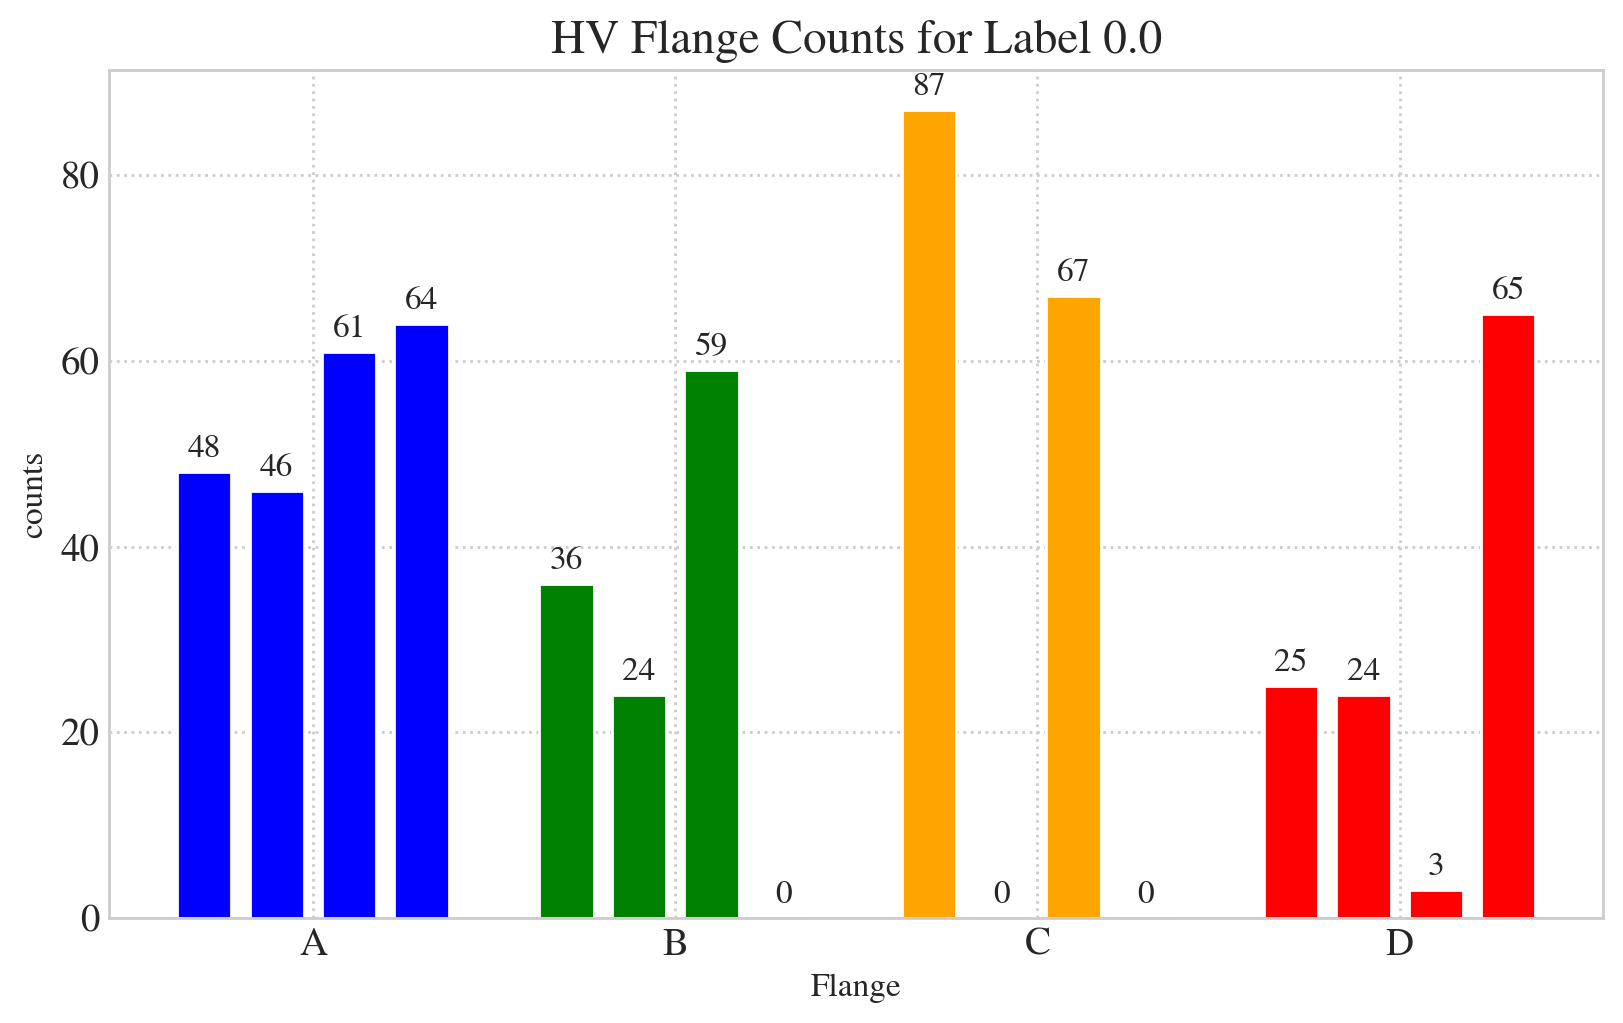

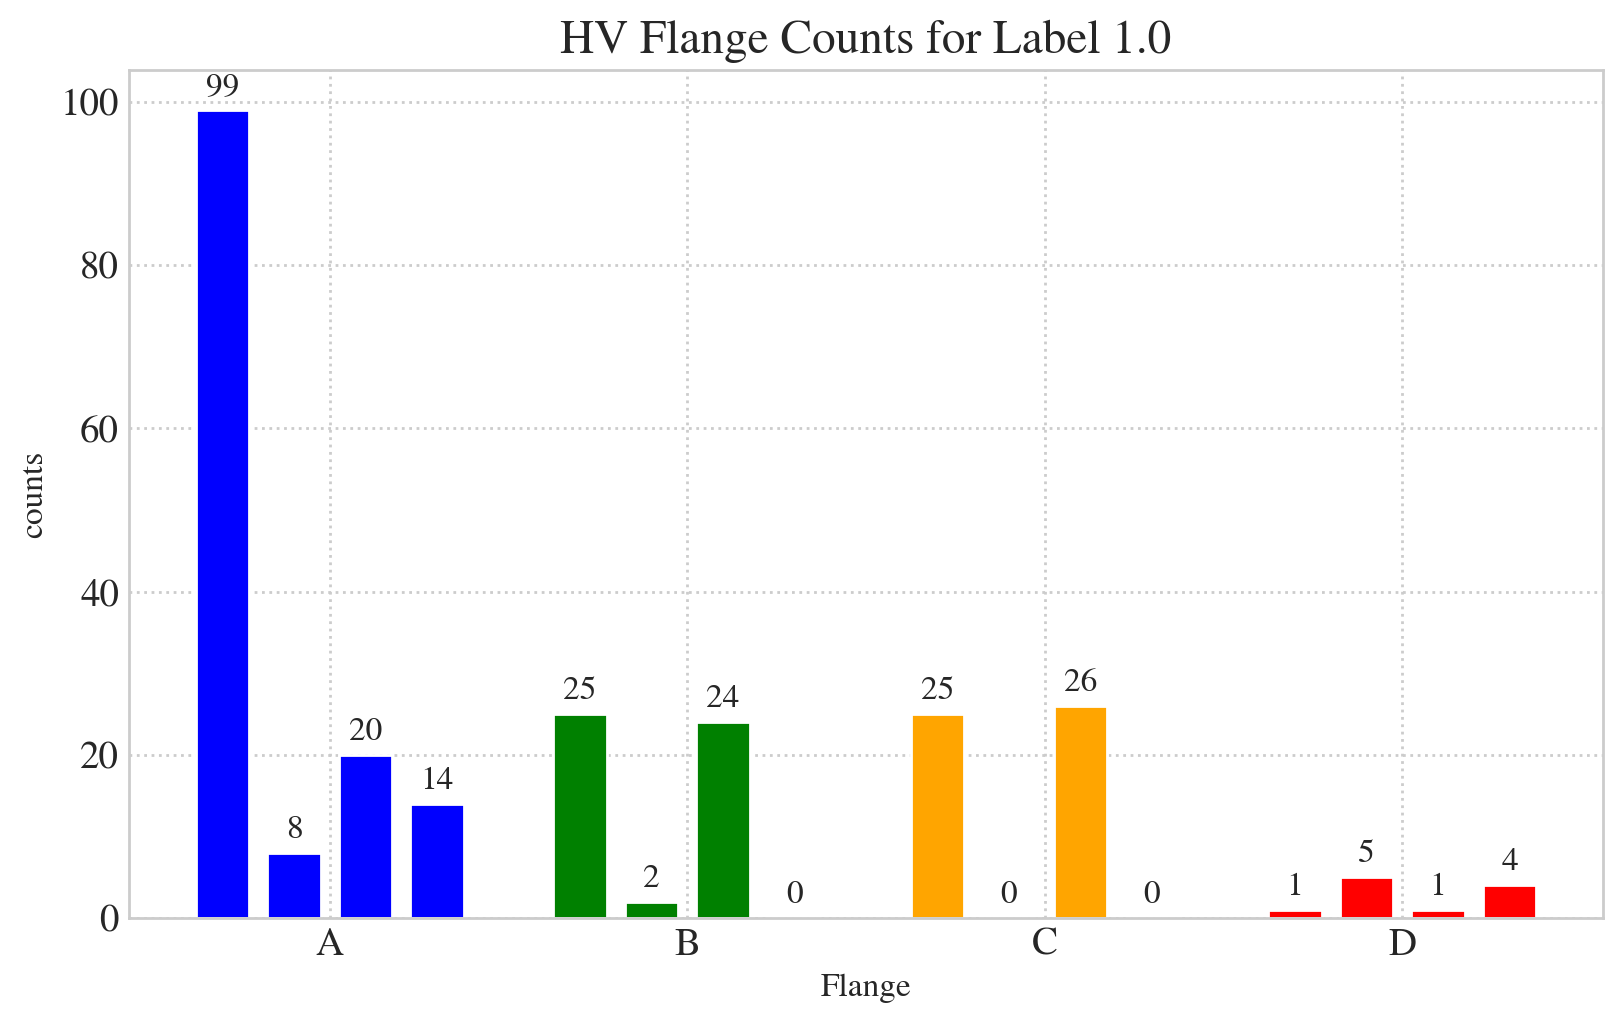

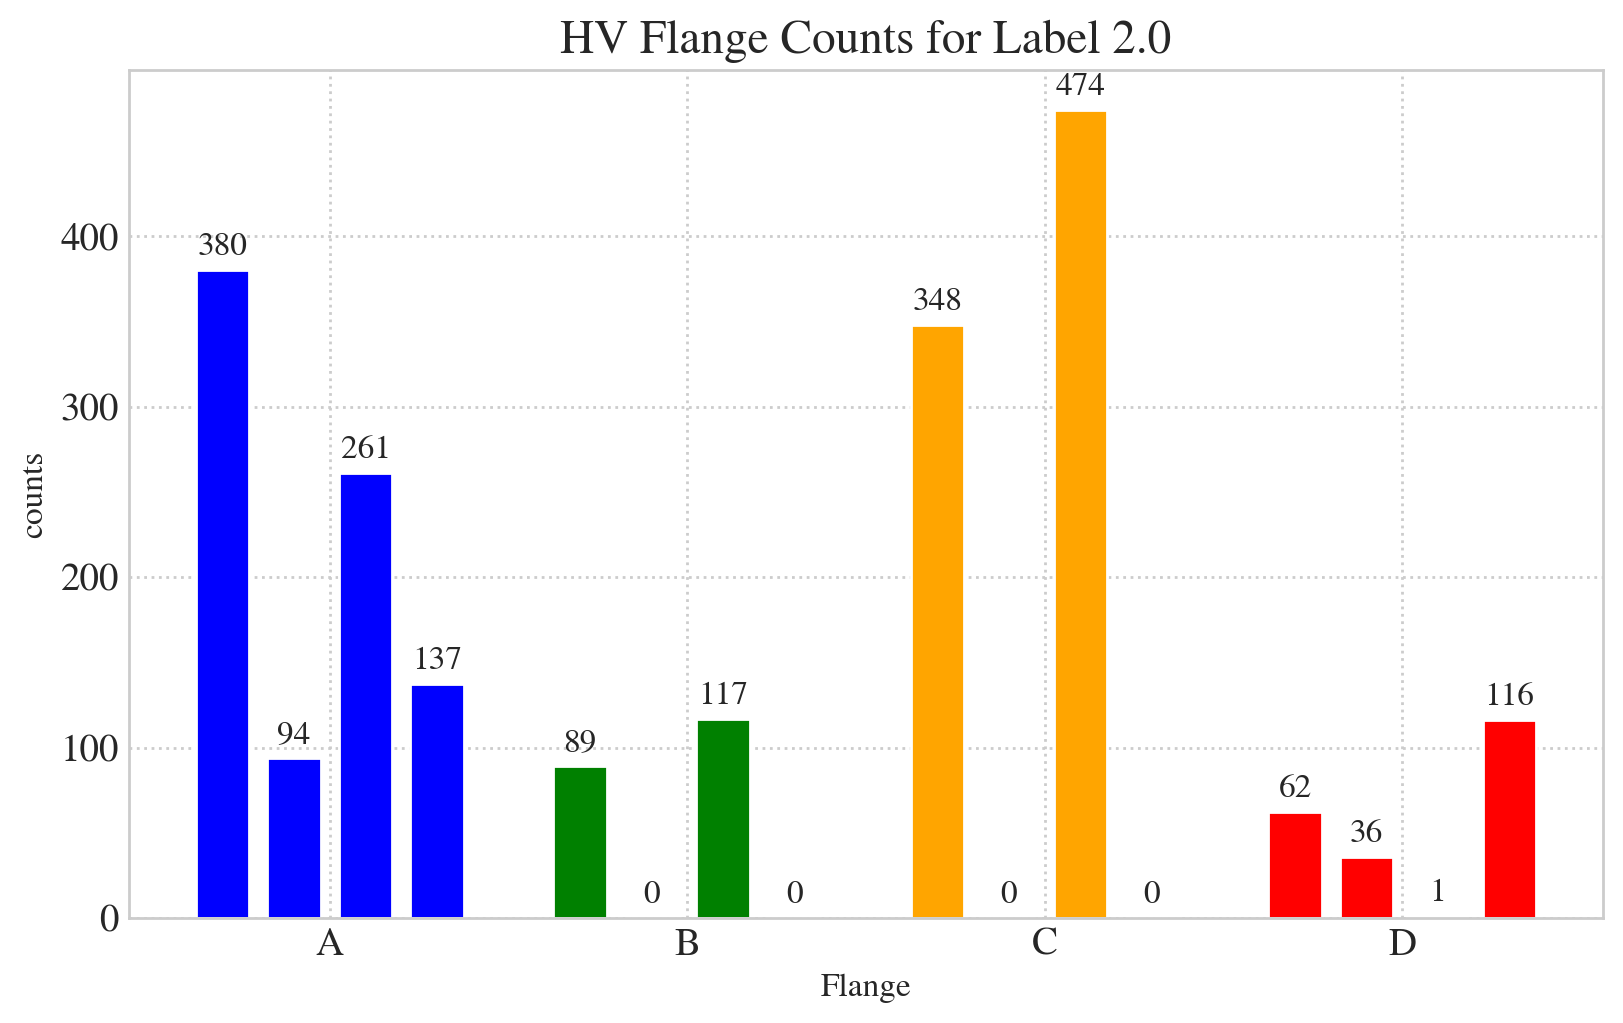

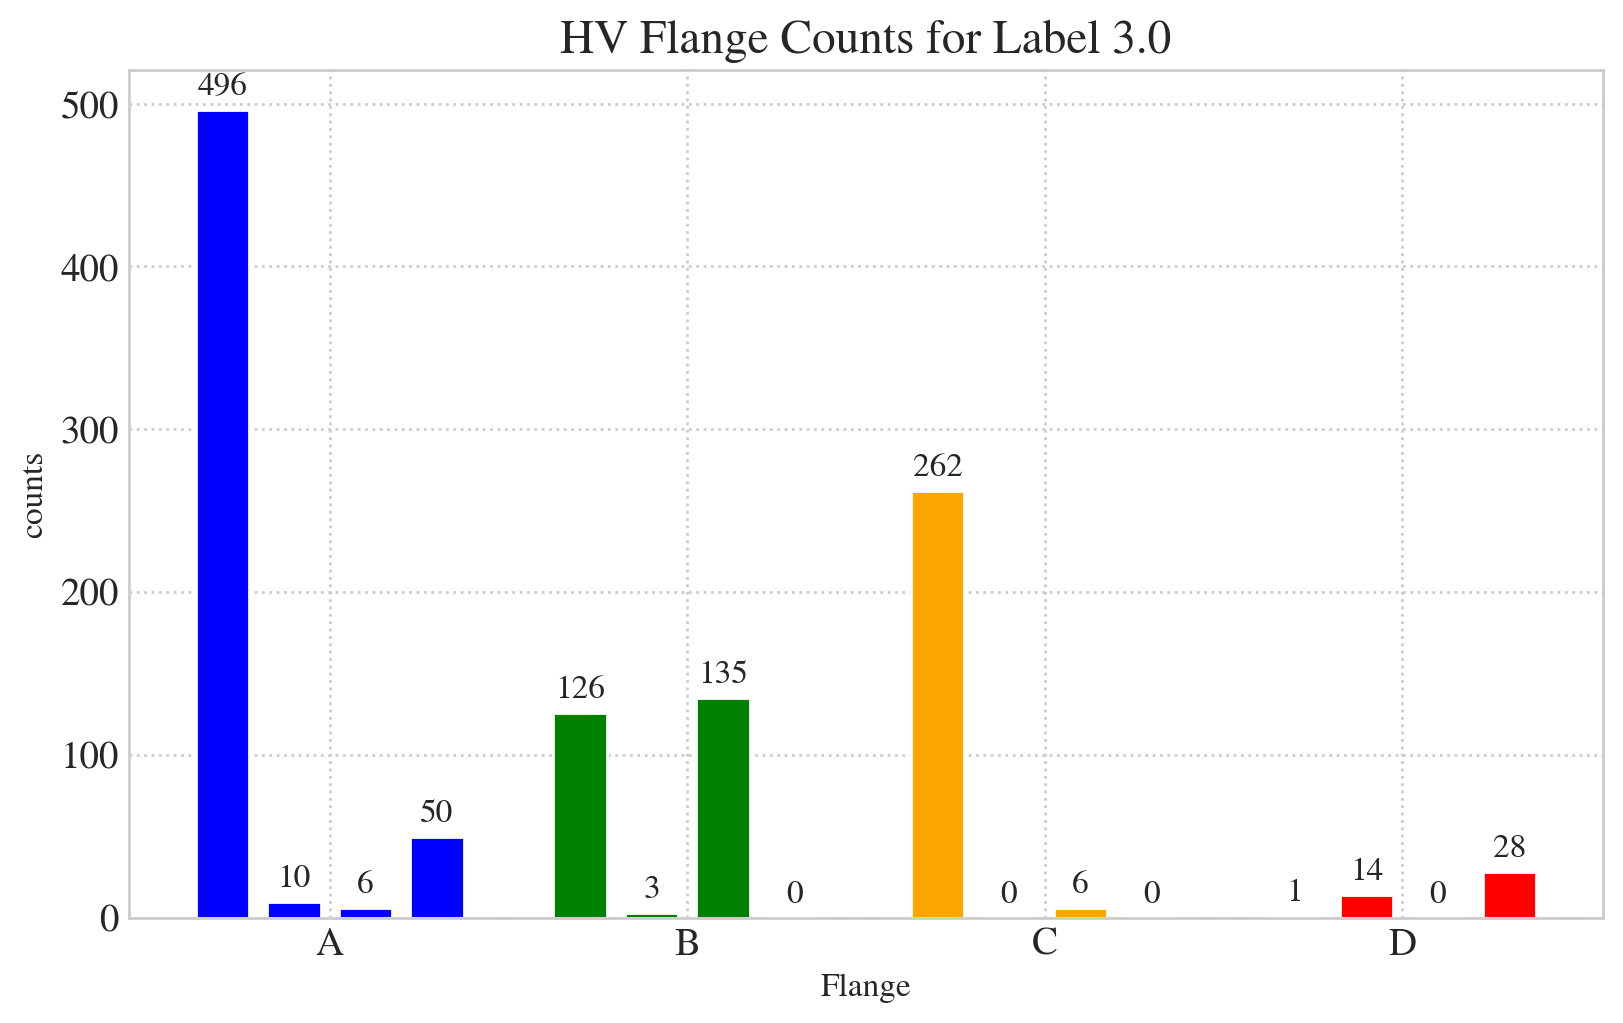

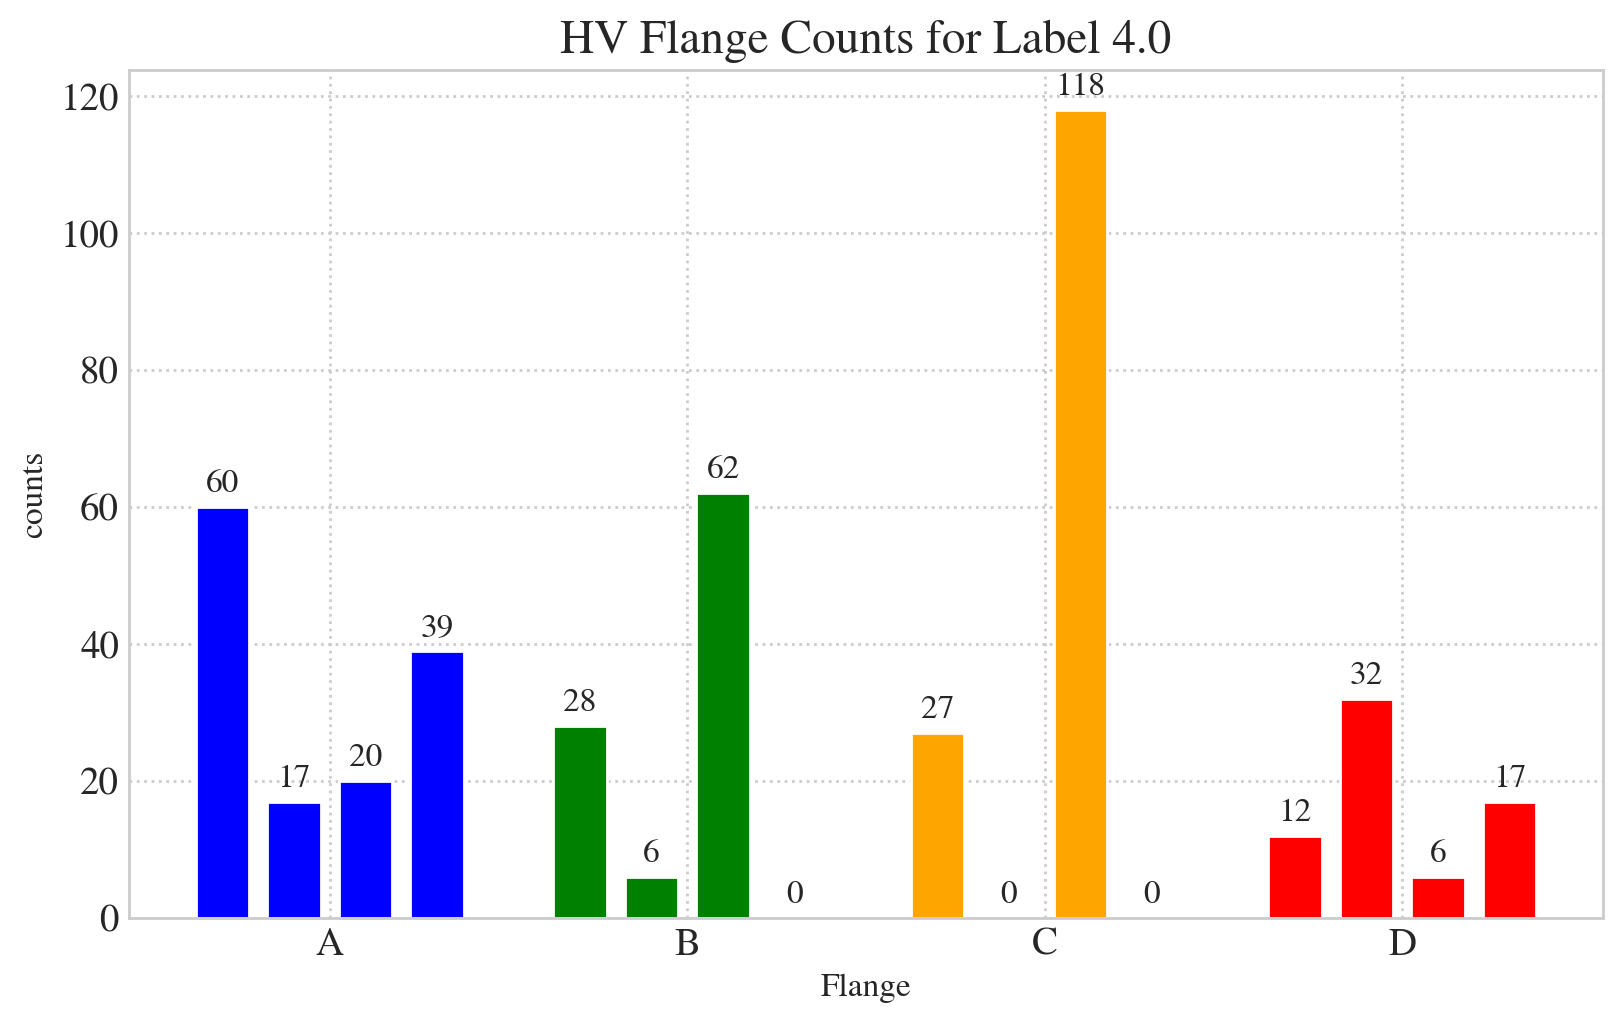

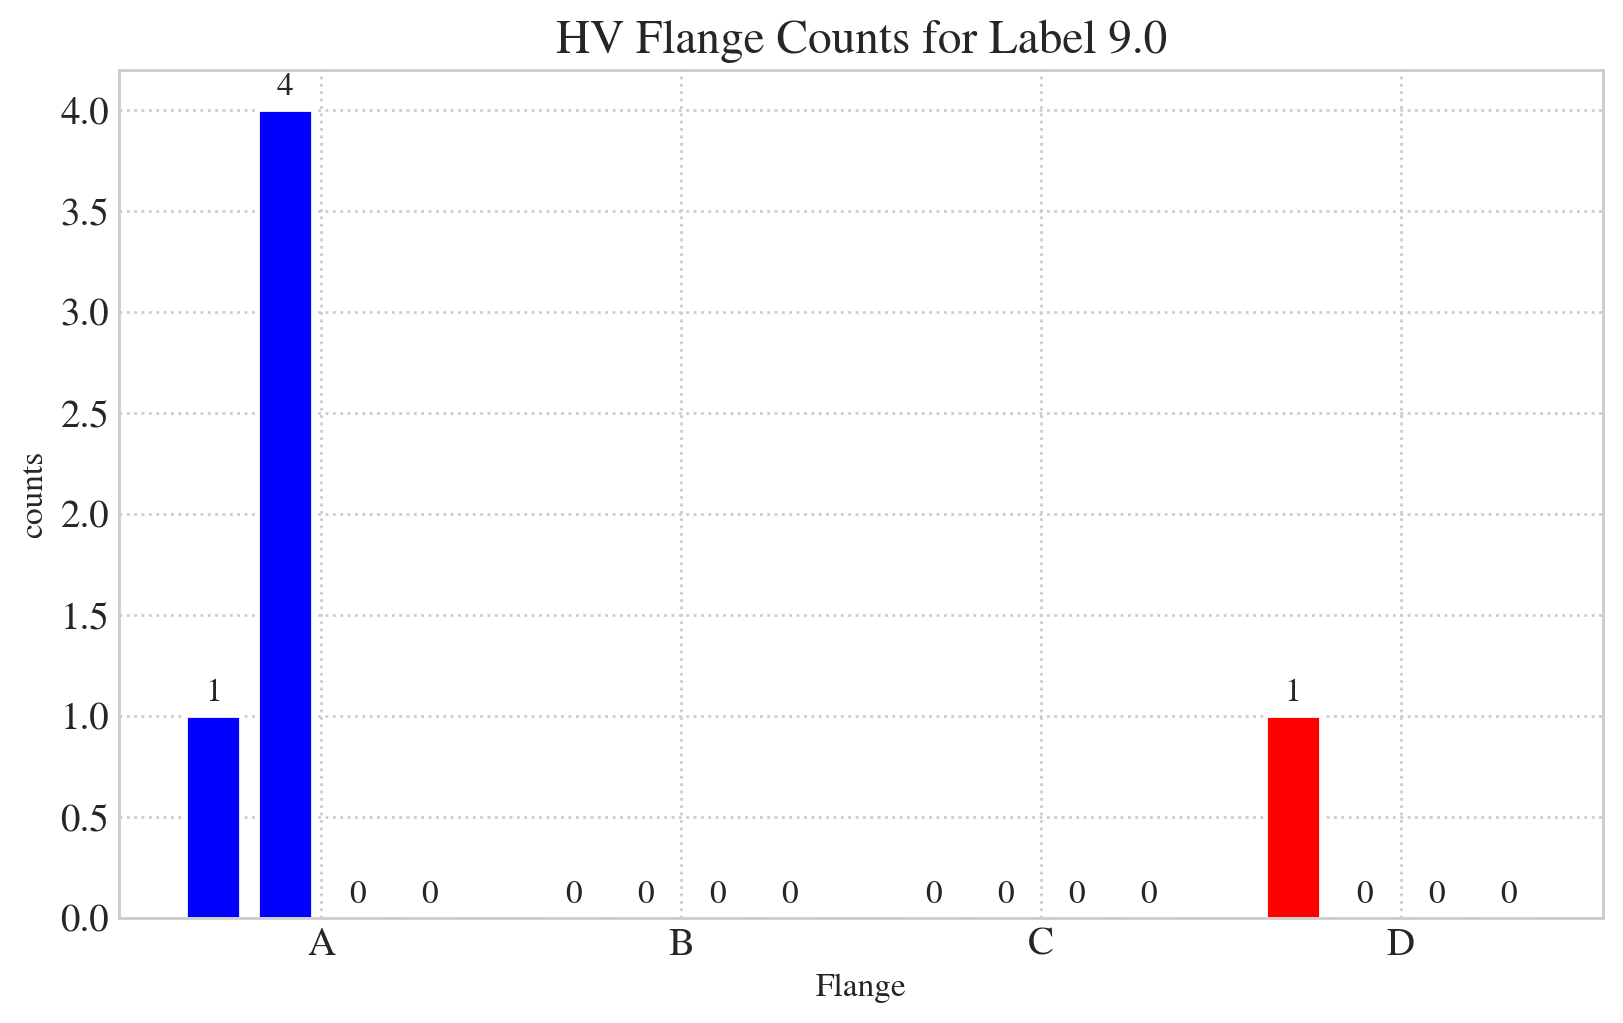

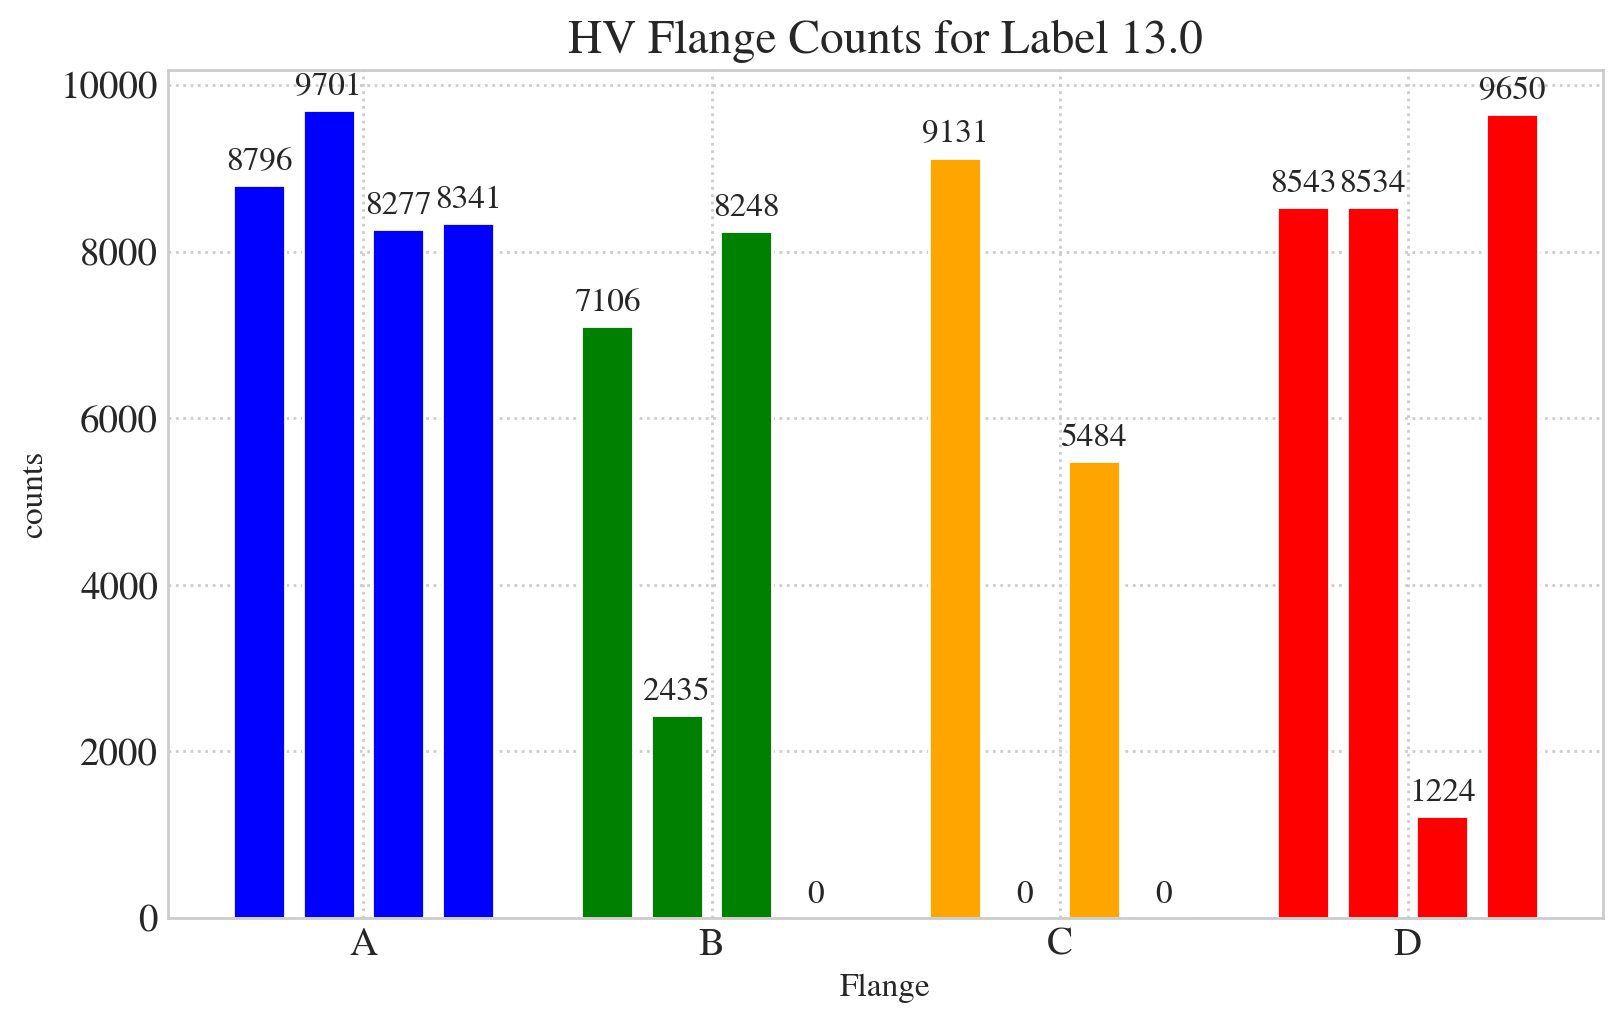

In [18]:
RowsT, HV_labelsT = flange_dict(HV_flange, Labels)

This is for making a grid of the selection of some categories and some of the anomalous labels

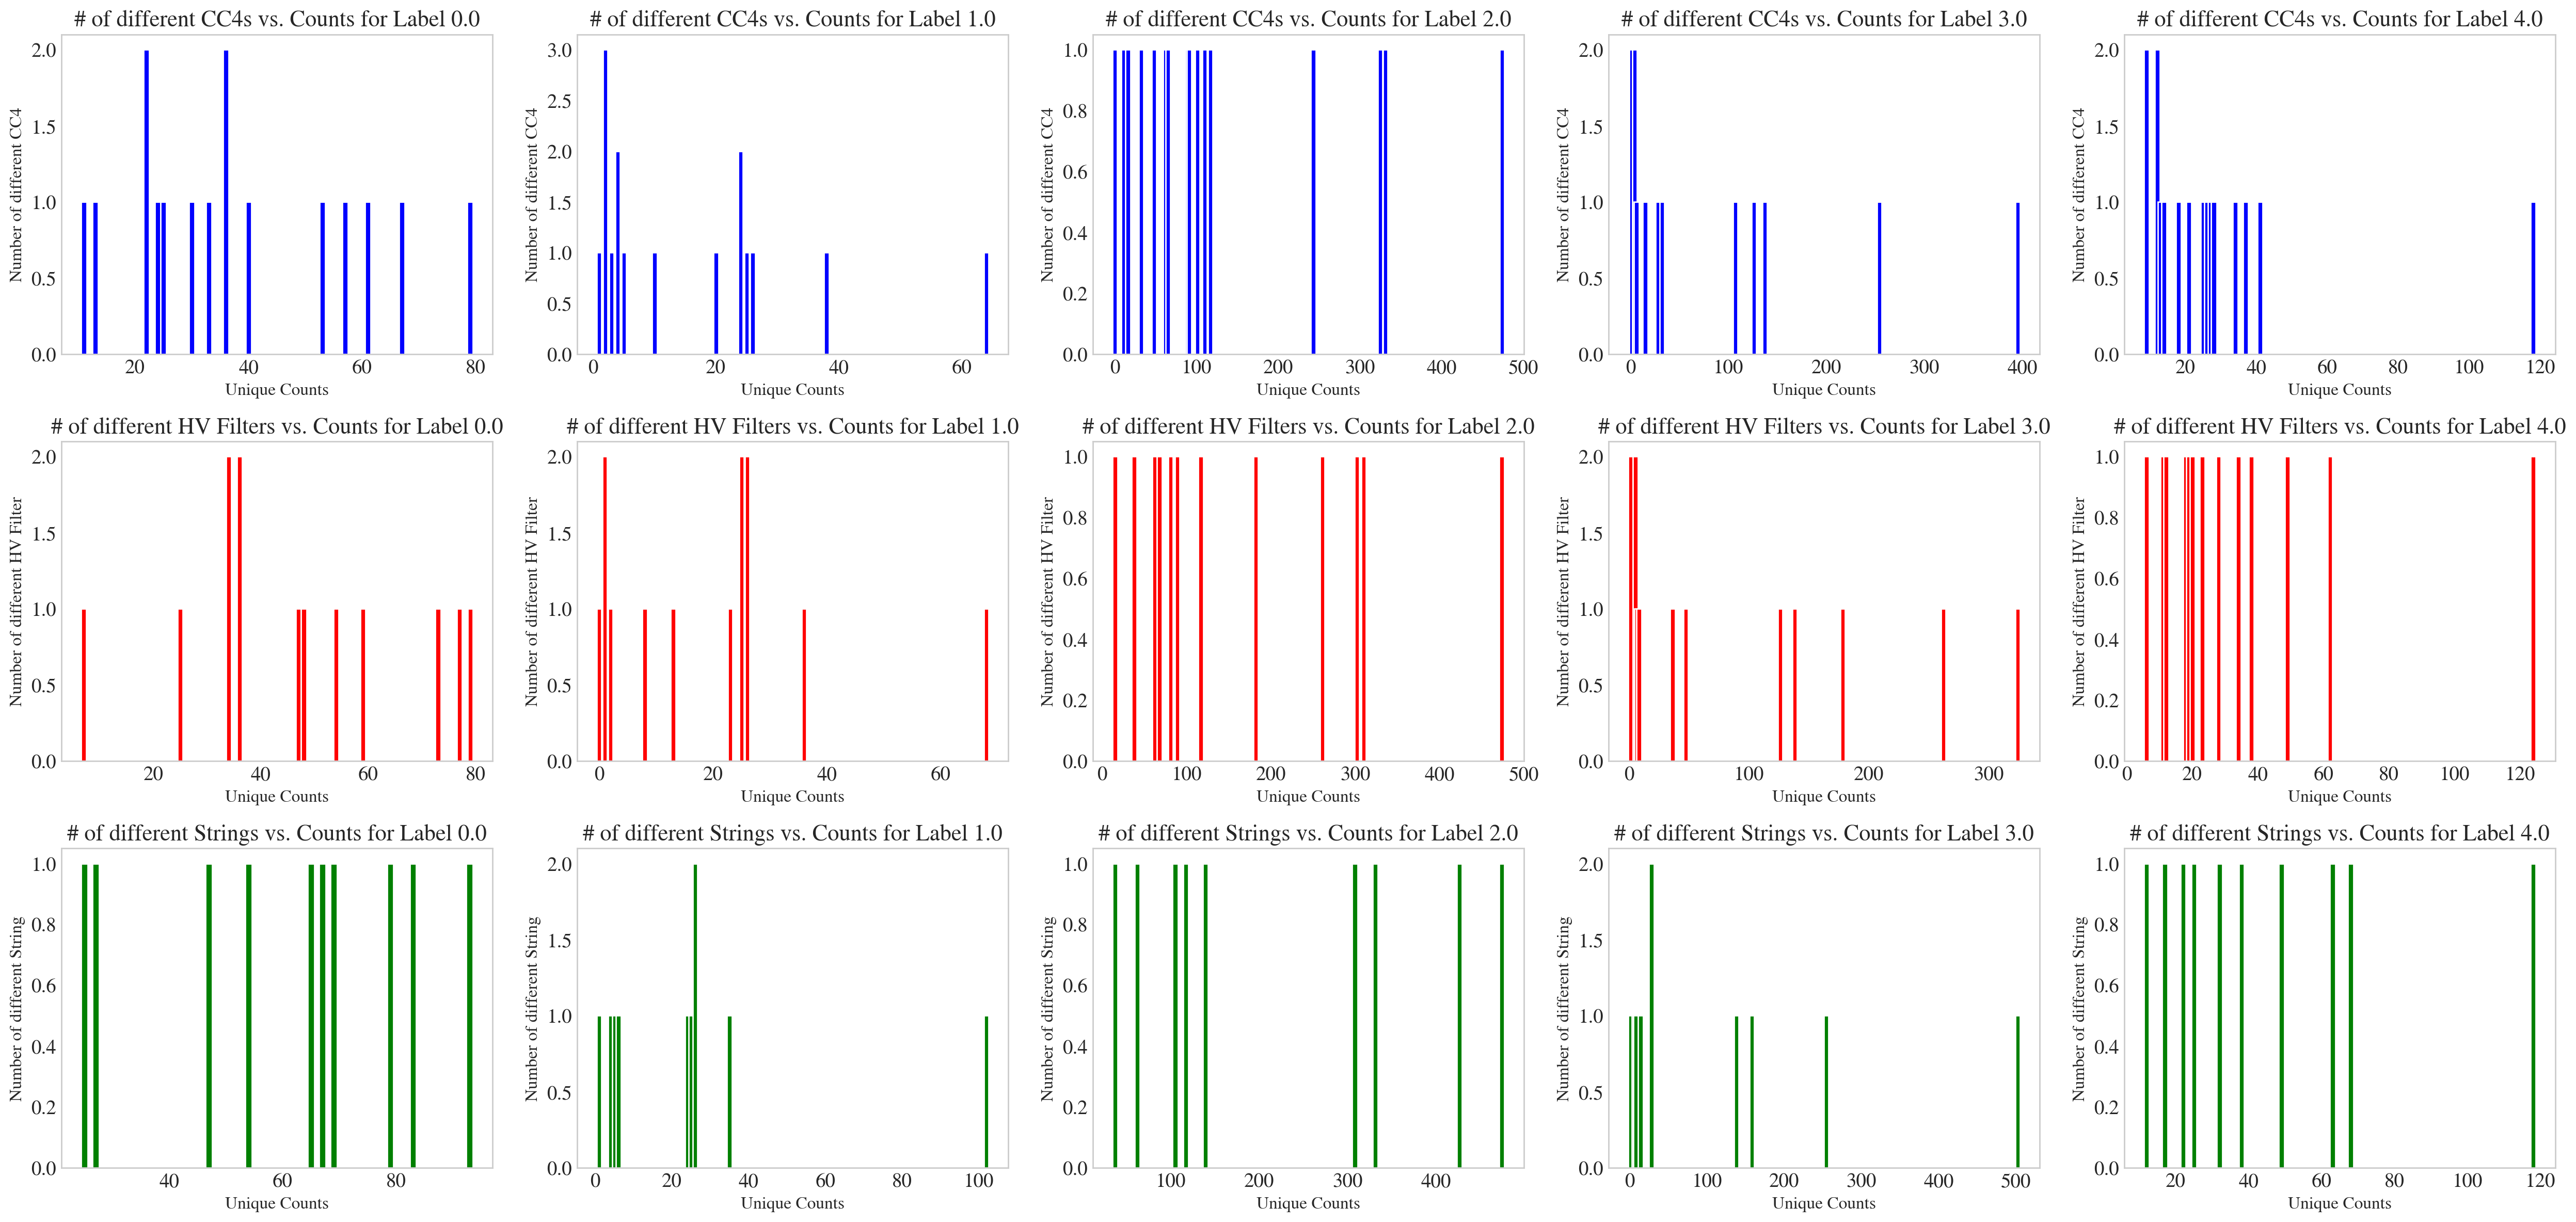

In [20]:
Cat_grid = [CC4_Counter, Voltage_Counter, String_Counter]
Cat_names = ["CC4", "HV Filter", "String"]
colorS = ["blue", "red", "green"]
unique_labels = np.unique(Labels)

fig = plt.figure(figsize=(35,12))

# Calculate the number of rows and columns in the subplots grid
rows = len(Cat_grid)
cols = max(len(cat) for cat in Cat_grid) #useful if uneven counters generated from the different options in the function

for k, cat in enumerate(Cat_grid):
    # Extract the keys from the dictionary and ignore the first and last two keys
    keys_to_plot = list(cat.keys())[0:-2]

    for label in keys_to_plot:
        ax = fig.add_subplot(rows, cols, k * cols + keys_to_plot.index(label) + 1)  
        ax.set_title(f"Counts for {Cat_names[k]} for Label {label}", size=12, fontweight='bold')
        ax.grid(False)

        x_values = cat[label][0]  # Uniq_Counts
        y_values = cat[label][1]  # Num_channels

        # Calculate the interval width and bar width
        max_x = np.max(x_values)
        interv = 5
        interv_width = max_x / interv
        bar_wdth = interv_width / 16

        # Create the bar chart using the ax object
        ax.bar(x_values, y_values, width=bar_wdth, color = colorS[k])

        # Customize the plot
        ax.set_xlabel('Unique Counts')
        ax.set_ylabel(f'Number of different {Cat_names[k]}')
        ax.set_title(f'# of different {Cat_names[k]}s vs. Counts for Label {label}', fontsize=16)

plt.savefig("cat_grid_C.png", dpi = 400)


/tmp/ipykernel_2139602/3799998723.py:85: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig('3d_channel_list.png', dpi = 300)


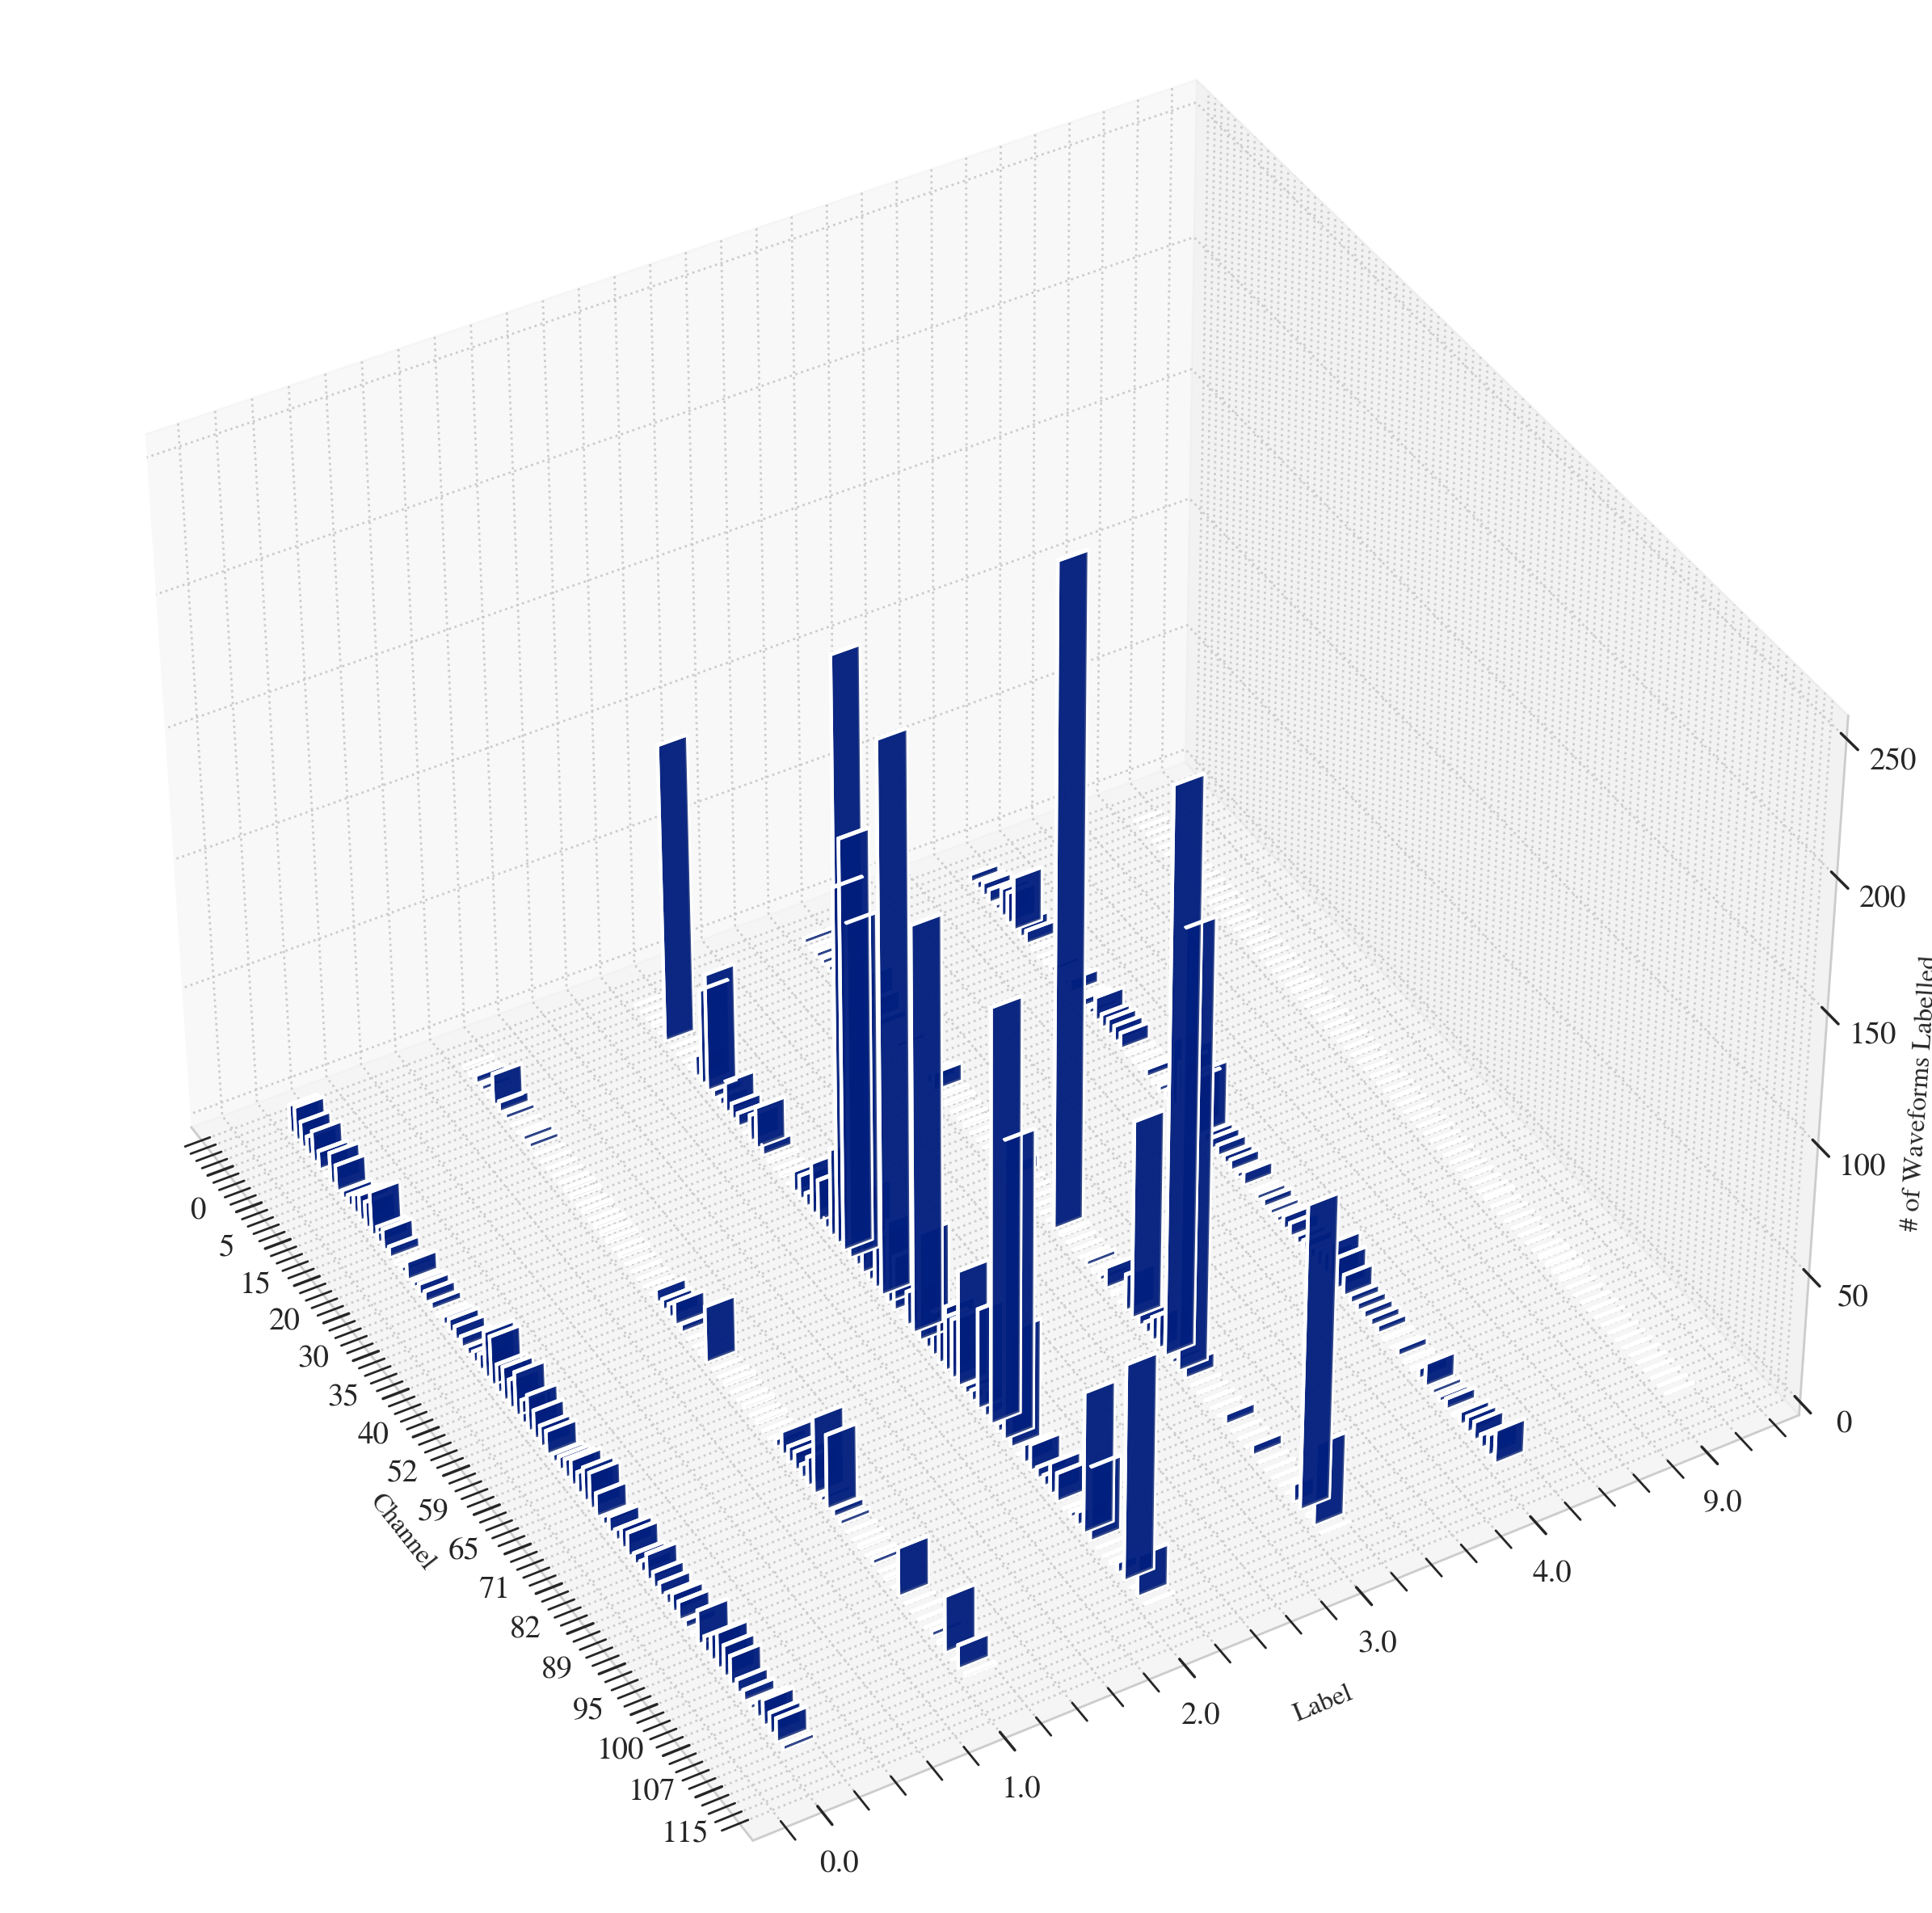

In [118]:
top_channels, Channels_Counter = Channel_counter(Channels, Labels, "Channels", Noise = True, Hist = True, Show_top_counts = False)

In case you want a dictionary with all the top information for the metadata chosen.


In [21]:
top_metadata_dict = {"CC4": ': {}'.format(top_CC4),
                     "HV Filter": ': {}'.format(top_Voltage),
                     "Strings": ': {}'.format(top_String),
                     "Detector Name": ': {}'.format(top_name),
                     "Channels": ': {}'.format(top_channels)}

# Plot the Category Counters in Bar Plots
We can look at the frequency different objects under each category appear in the data as a 2-D bar plot, for each label

In [87]:
def Counter_plotter(Counter, Layer_string):
    
    fig = plt.figure(figsize=(20,10))
    keys_to_plot = [0.0, 1.0, 2.0, 3.0, 4.0, 13.0] #don't want saturated ones --- 9.0
    rows = 2
    cols = 3
    colors = ['blue', 'green', 'red', 'cyan', 'fuchsia', 'purple']

    for k, label in enumerate(keys_to_plot):
        ax = fig.add_subplot(rows, cols, k  + 1)  
        ax.set_title(f"Counts for {Layer_string} for Label {label}", size=20, fontweight='bold')
        ax.grid(False)        

        x_values = Counter[label][0]  # Uniq_Counts
        y_values = Counter[label][1]  # Num_channels
        #print(f'Number of unique counts: {x_values}')
        #print(f'Number of different {Layer_string}: {y_values}')

        #
        max_x = np.max(x_values)
        interv = 5
        interv_width = max_x / interv
        bar_wdth = interv_width / 16
        ax.bar(x_values, y_values, width = bar_wdth, color = colors[k])

        # Customize the plot
        plt.xlabel('Unique Counts')
        plt.ylabel(f'Number of different {Layer_string}')
        plt.title(f'# of different {Layer_string} vs. # of Waveforms labelled {label}')

        xticks = np.arange(np.min(x_values), max_x + interv_width, interv_width)
        xtick_labels = np.arange(np.min(x_values), interv + 1)
    flname = Layer_string + ".png"
    plt.savefig(flname, dpi = 300)

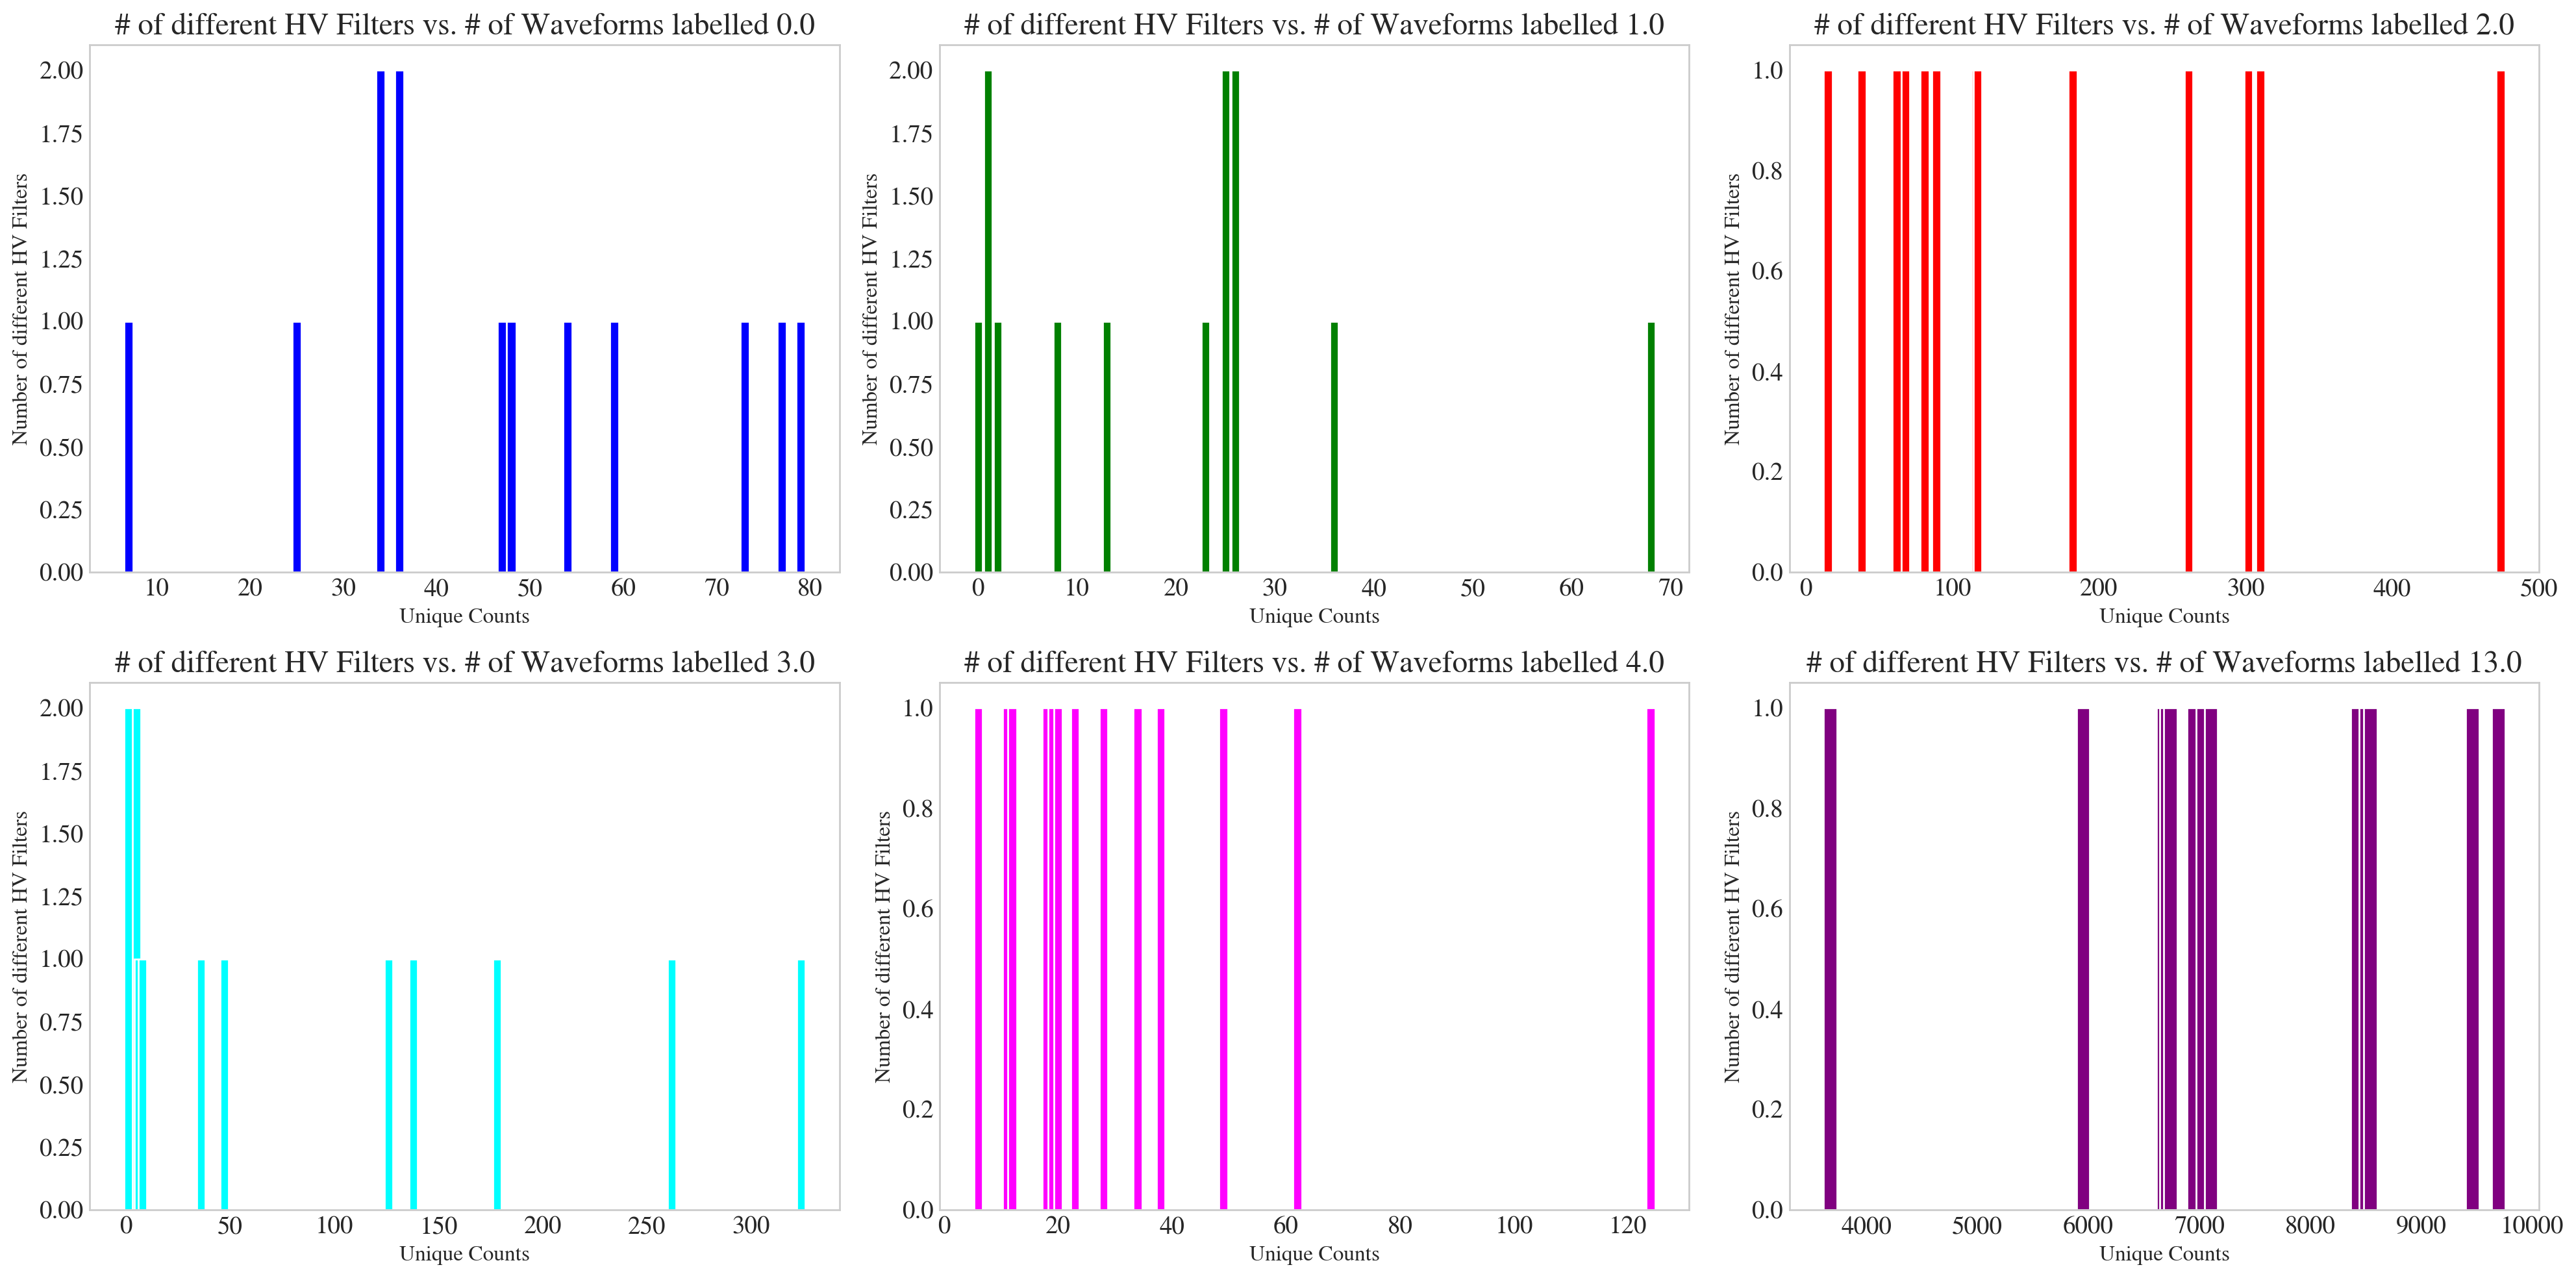

In [112]:
Counter_plotter(Voltage_Counter, "HV Filters")

In [126]:
from scipy.stats import poisson
def Counter_Histogram(Counter, Layer_string):
        
    fig = plt.figure(figsize=(30,10))
    keys_to_plot = [0.0, 1.0, 2.0, 3.0, 4.0, 13.0] #don't want saturated ones
    rows = 2
    cols = 3
    colors = ['blue', 'green', 'red', 'cyan', 'fuchsia', 'purple']
    
    for k, label in enumerate(keys_to_plot):
        ax = fig.add_subplot(rows, cols, k  + 1)  
        ax.grid(False)    
        
        
        x_values = np.array(Counter[label][0])  # Uniq_Counts
        y_values = np.array(Counter[label][1])  # Num_channels
        DATA = np.repeat(x_values, y_values) #needed for plt.hist
        #print(f'Number of unique counts: {x_values}')
        #print(f'Number of different {Layer_string}: {y_values}')

        lambda_param = np.mean(DATA) #poisson distribution
        
        # Plot the histogram and Poisson distribution
        ax.hist(DATA, bins=np.arange(min(DATA), max(DATA)+1, 1), density=True, alpha=0.7, color = colors[k])
        x = np.arange(min(DATA), max(DATA)+1, 1)
        poisson_dist = poisson.pmf(x, lambda_param)
        ax.plot(x, poisson_dist, marker='o', linestyle='-', label=f'Poisson (λ={lambda_param:.2f})', color = 'maroon')
        plt.xlabel("Number of unique counts")
        plt.ylabel(f"Probability of seeing {Layer_string}")
        ax.legend(loc = 'upper right')
        ax.set_title(f"Poisson Distribution Fit for # of different {Layer_string} vs. # of Waveforms labelled {label}")
        

    flname = "Poisson_"+Layer_string + ".png"
    plt.savefig(flname, dpi = 300)

KeyError: 13.0

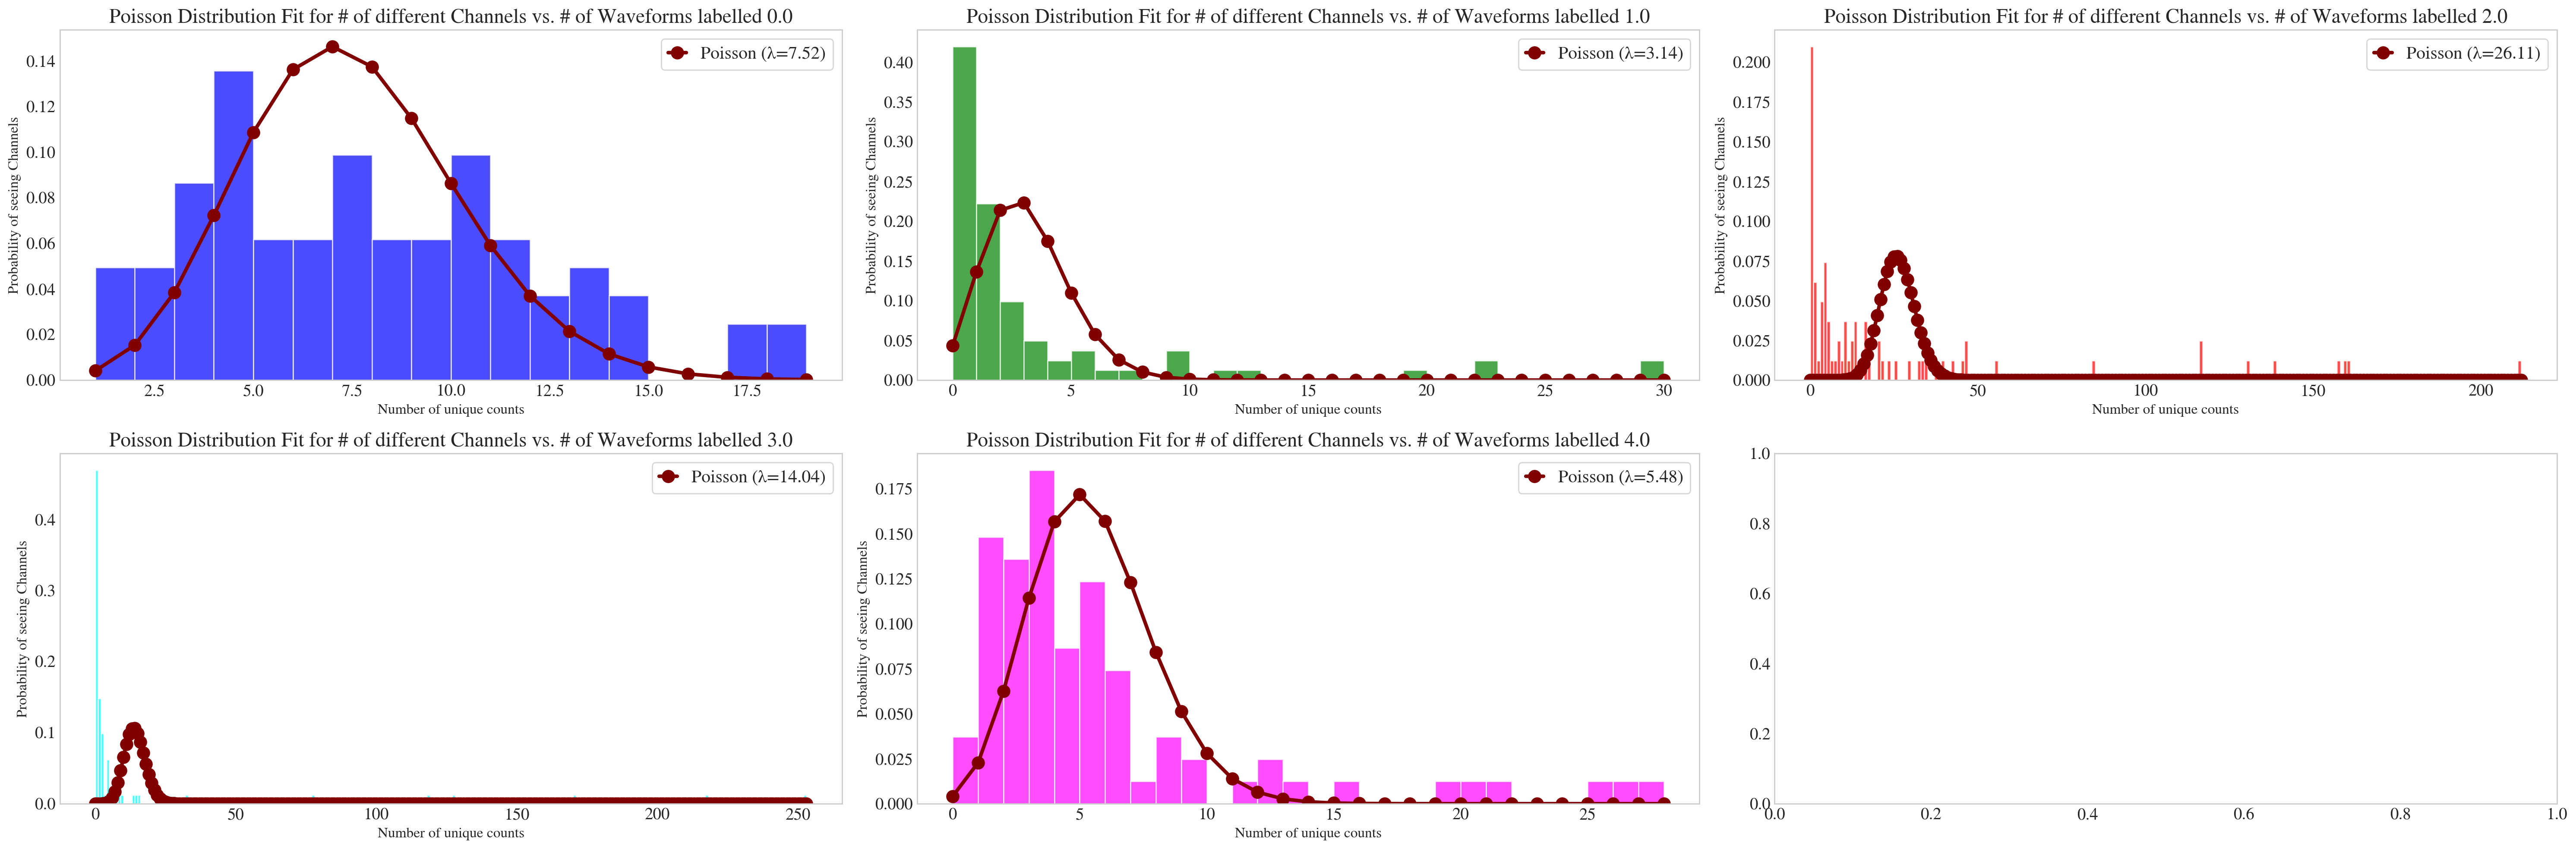

In [127]:
Counter_Histogram(Channels_Counter, "Channels") #hits an error because uneven number of plots, but isn't a problem